# Supplementary Material

Exploring defining single value indices - SPI

Andrew Mitchell
[](https://orcid.org/0000-0003-0978-5046)
(University College London)  
2024-10-28

# Exploring defining single value indices - SPI

This notebook contains several explorations and developments leading to
the SPI framework.

# Setup

## Import Libraries

In [1]:
import soundscapy as sspy
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import seaborn as sns
from scripts import msn_utils
import scripts.rpyskewnorm as snpy
import numpy as np
from scripts.MultiSkewNorm import MultiSkewNorm

import warnings

warnings.filterwarnings("ignore")

/Users/mitch/Library/CloudStorage/OneDrive-UniversityCollegeLondon/_Fellowship/Papers - Drafts/J2401_JASA_SSID-Single-Index/.venv/lib/python3.11/site-packages/rpy2/robjects/numpy2ri.py:241: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/Users/mitch/Library/CloudStorage/OneDrive-UniversityCollegeLondon/_Fellowship/Papers - Drafts/J2401_JASA_SSID-Single-Index/.venv/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '

## Load Data

In addition to loading the latest version of the ISD, we also exclude a
few samples that were identified as survey outliers. Most notably, this
includes the samples at RegentsParkFields which were impacted by
helicopter flyovers.

In [2]:
# Load latest ISD dataset

data = sspy.isd.load()
data, excl_data = sspy.isd.validate(data)
data = data.query("Language != 'cmn'")

# Exclude RegentsParkJapan outliers
# excl_id = list(data.query("LocationID == 'RegentsParkJapan'").query("ISOEventful > 0.72 | ISOEventful < -0.5").index)
# Excluded RegentsParkFields outliers
# excl_id = excl_id + list(data.query("LocationID == 'RegentsParkFields' and ISOPleasant < 0").index) # Helicopters
excl_id = [652, 706, 548, 550, 551, 553, 569, 580, 609, 618, 623, 636, 643]
data.drop(excl_id, inplace=True)
data

1648 rows × 142 columns

### ISOCoordinate calculation according to Aletta et. al. (2024)

To move the 8-item PAQ responses into the 2-dimensional circumplex
space, we use the projection method first presented in ISO 12913-3:2018.
This projection method and its associated formulae were recently updated
further in (**Aletta2024?**) to include a correction for the language in
which the survey was conducted. The formulae are as follows:

$$
% \begin{align*}
P_{ISO} = \frac{1}{\lambda_{pl}} \sum_{i=1}^{8} \cos \theta_i \cdot \sigma_i \\
E_{ISO} = \frac{1}{\lambda_{pl}} \sum_{i=1}^{8} \sin \theta_i \cdot \sigma_i 
% \end{align*}
$$

where \$\_i\$ is the response to the (i)th item of the PAQ. The
resulting (x) and (y) values are then used to calculate the polar angle
() and the radial distance (r) as follows:

In [3]:
from soundscapy.surveys.survey_utils import LANGUAGE_ANGLES, PAQ_IDS

LANGUAGE_ANGLES

{'eng': (0, 46, 94, 138, 177, 241, 275, 340),
 'arb': (0, 36, 45, 135, 167, 201, 242, 308),
 'cmn': (0, 18, 38, 154, 171, 196, 217, 318),
 'hrv': (0, 84, 93, 160, 173, 243, 273, 354),
 'nld': (0, 43, 111, 125, 174, 257, 307, 341),
 'deu': (0, 64, 97, 132, 182, 254, 282, 336),
 'ell': (0, 72, 86, 133, 161, 233, 267, 328),
 'ind': (0, 53, 104, 123, 139, 202, 284, 308),
 'ita': (0, 57, 104, 143, 170, 274, 285, 336),
 'spa': (0, 41, 103, 147, 174, 238, 279, 332),
 'swe': (0, 66, 87, 146, 175, 249, 275, 335),
 'tur': (0, 55, 97, 106, 157, 254, 289, 313)}

In [4]:
tab = pd.DataFrame.from_dict(LANGUAGE_ANGLES, orient='index', columns=PAQ_IDS)
tab

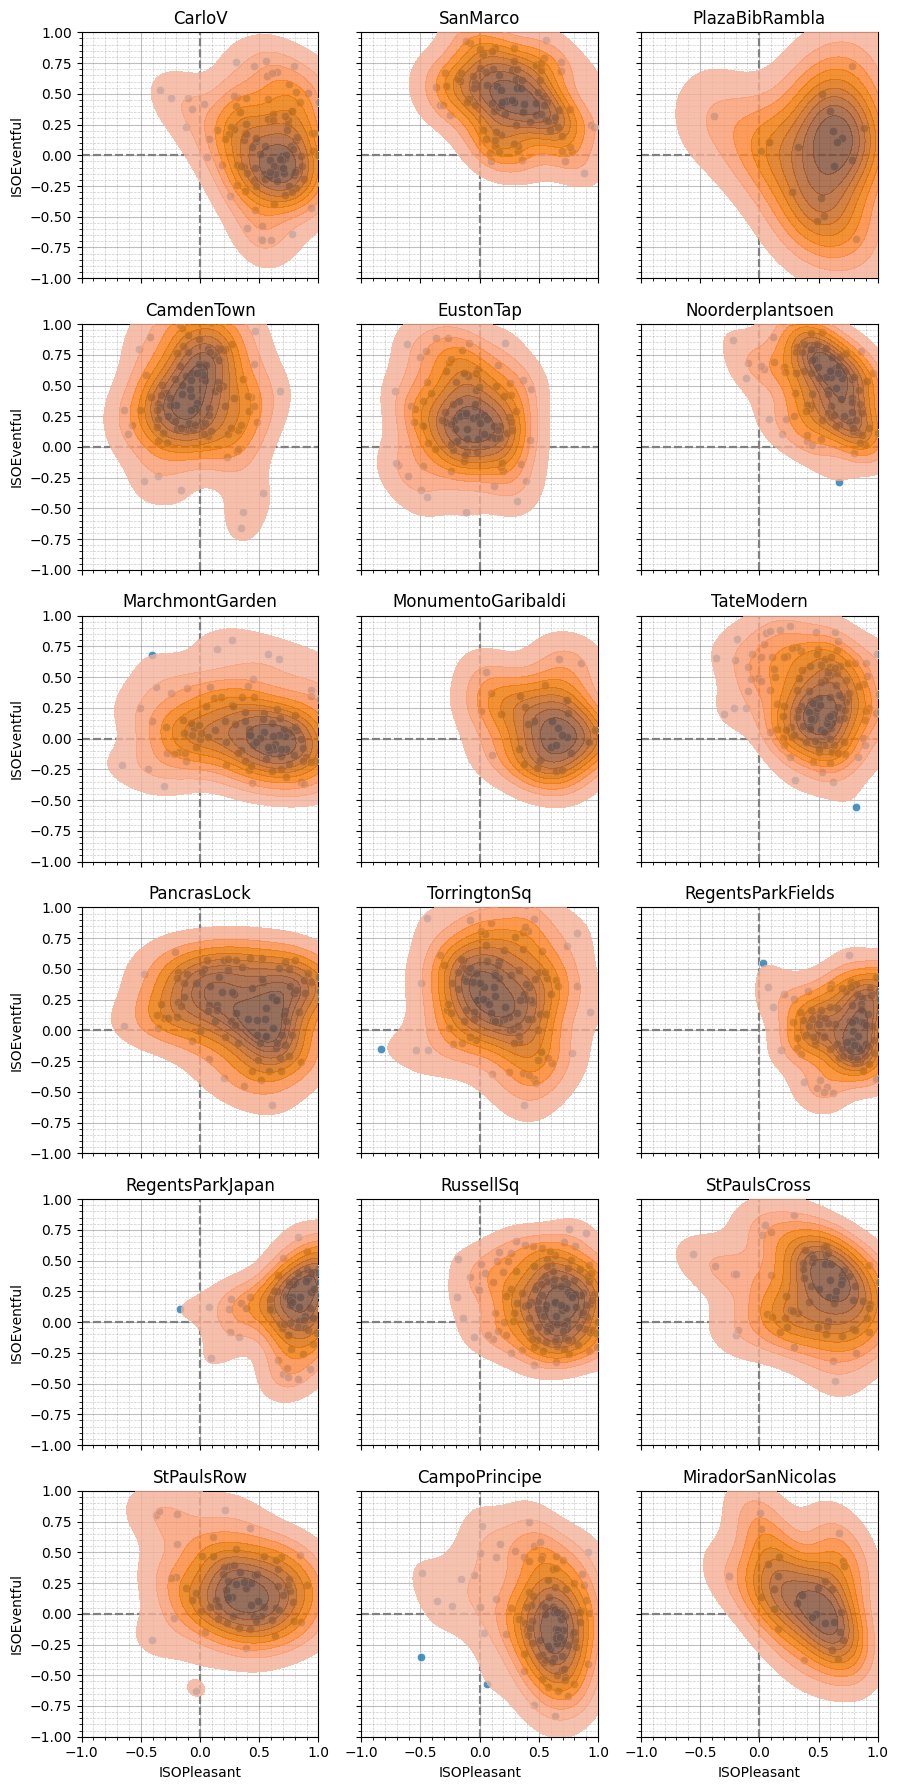

In [5]:
from soundscapy.surveys.survey_utils import PAQ_IDS

for i, row in data.iterrows():
    lang = row["Language"]
    angles = LANGUAGE_ANGLES[lang]
    iso_pl, iso_ev = (
        sspy.surveys.processing._adj_iso_pl(row[PAQ_IDS], angles, scale=4),
        sspy.surveys.processing._adj_iso_ev(row[PAQ_IDS], angles, scale=4),
    )
    data.loc[i, "ISOPleasant"] = iso_pl
    data.loc[i, "ISOEventful"] = iso_ev

fig, axes = plt.subplots(6, 3, figsize=(9, 18), sharex=True, sharey=True)
for i, (loc, ax) in enumerate(zip(data.LocationID.unique(), axes.flatten())):
    sspy.density_plot(
        data.query(f"LocationID == '{loc}'"),
        ax=ax,
        title=loc,
        # hue='Language',
    )

fig.tight_layout()

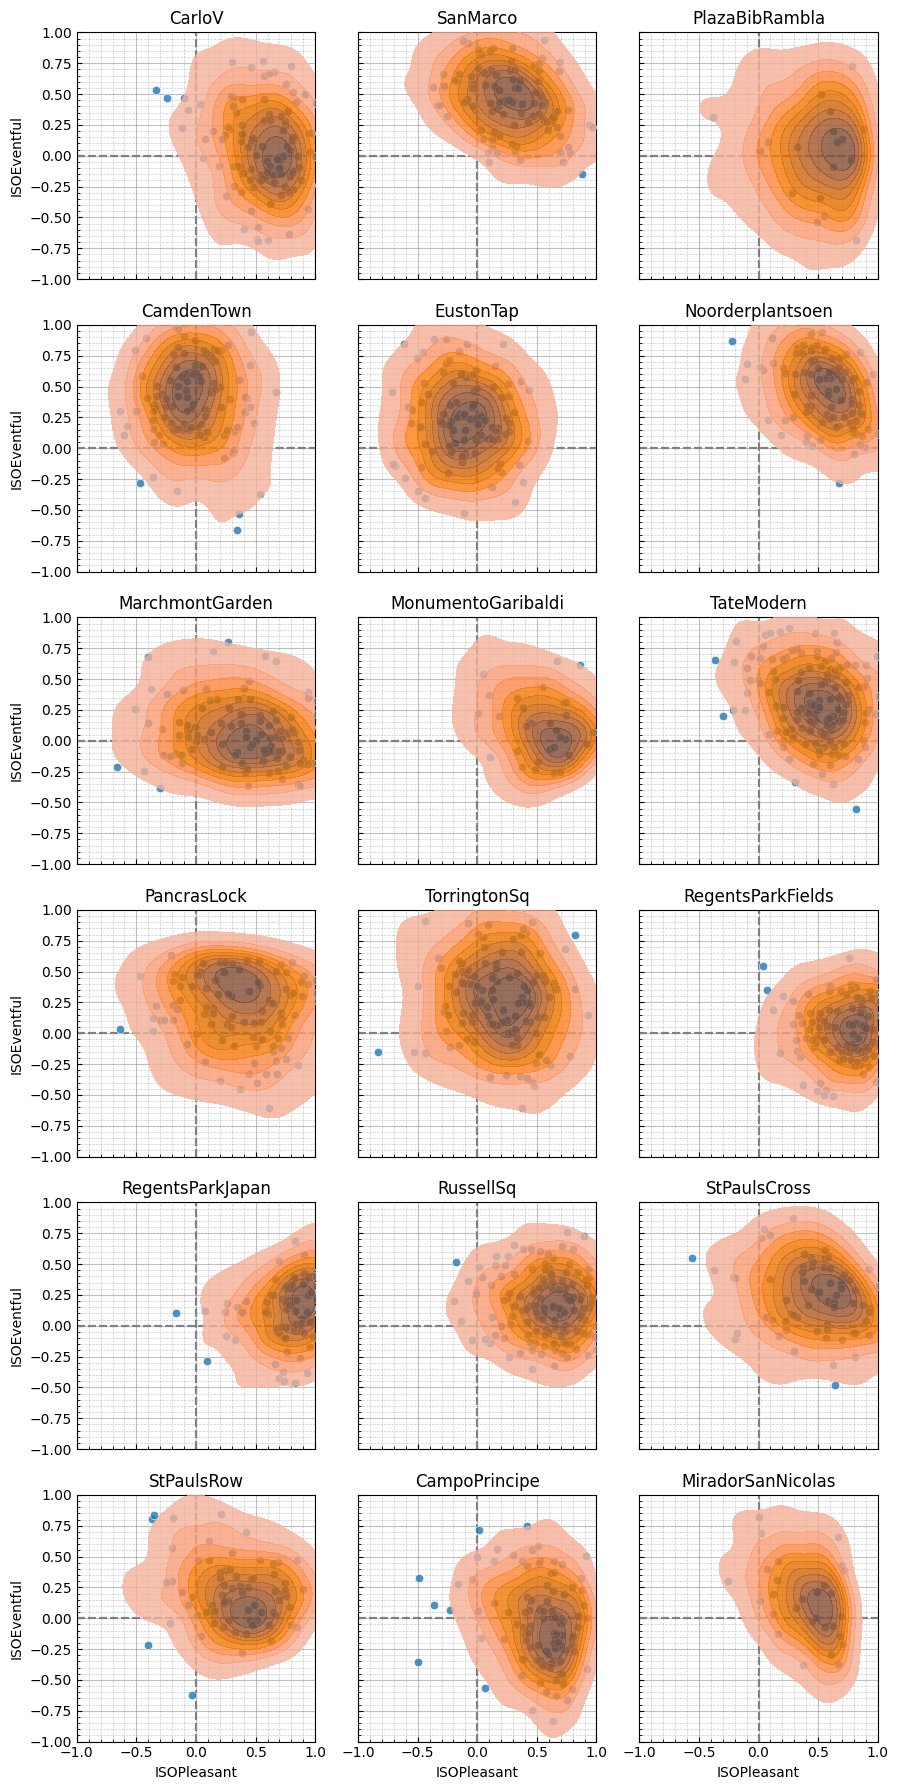

In [6]:
# Plotting distribution density with empirical scatter

fig, axes = plt.subplots(6, 3, figsize=(9, 18), sharex=True, sharey=True)
for i, (loc, ax) in enumerate(zip(data.LocationID.unique(), axes.flatten())):
    loc_msn = MultiSkewNorm()
    loc_msn.fit(
        data=data.query(f"LocationID == '{loc}'")[["ISOPleasant", "ISOEventful"]]
    )
    loc_msn.sample(1000)
    loc_Y = pd.DataFrame(loc_msn.sample_data, columns=["ISOPleasant", "ISOEventful"])

    sspy.scatter_plot(
        data.query(f"LocationID == '{loc}'"),
        ax=ax,
        title=loc,
    )
    sspy.density_plot(
        loc_Y,
        ax=ax,
        title=loc,
        incl_scatter=False,
        # hue='Language',
    )

fig.tight_layout()

## The Soundscape Perception Index (SPI)

The SPI works by assessing the assessed (or calculated) distribution of
soundscape responses against a target distribution. This target
distribution represents the goal for the soundscape design. Since we
consider a location’s soundscape perception to be the collective
perception of its users, it is crucial that the target includes both the
central tendency and the distribution.

### Note: Distributions in the circumplex

We should begin by discussing how soundscape circumplex distributions
are defined. The circumplex is defined by two axes: $P_{ISO}$ and
$E_{ISO}$ which are limited to the range $[-1,1]$. Typically the
distribution of collective perception of a soundscape is also not
symmetrical, therefore making it a skewed distribution. A soundscape
distribution is thus a two-dimensional truncated skew-normal
distribution.

The skew-normal distribution is defined by three parameters: location,
scale and shape. The location parameter defines the centre of the
distribution, the scale parameter defines the spread of the
distribution, and the shape parameter defines the skew of the
distribution. The skew-normal distribution is defined as:

$$
f(x; a, \omega, \alpha) = \frac{2}{\omega} \phi \left( \frac{x-a}{\omega} \right) \Phi \left( \alpha \frac{x-a}{\omega} \right)
$$

where $\phi$ and $\Phi$ are the standard normal probability density
function and cumulative distribution function respectively. The
skew-normal distribution is thus a generalisation of the normal
distribution, with the shape parameter $\alpha$ defining the skew. A
positive shape parameter results in a right-skewed distribution, and a
negative shape parameter results in a left-skewed distribution.

Truncated skew-normal distribution:
https://www-tandfonline-com.libproxy.ucl.ac.uk/doi/epdf/10.1080/03610910902936109?needAccess=true

To generate the truncated skew-normal distribution, we use rejection
sampling. This is a method of generating a distribution by sampling from
a simpler distribution and rejecting samples that do not fit the target
distribution. In this case, we sample from a skew-normal distribution
(`scipy.stats.skewnorm`) and reject samples that are outside of the
range $[-1,1]$.

#### Example - Calculating the moments of location’s distribution and generating the equivalent distribution using rejection sampling

In [7]:
test_loc = "SanMarco"
test_data = sspy.isd.select_location_ids(data, test_loc)

msn = MultiSkewNorm()
msn.fit(data=test_data[["ISOPleasant", "ISOEventful"]])

msn.summary()

Fitted from data. n = 96
Direct Parameters:
xi:    [[0.06  0.597]]
omega: [[ 0.15  -0.058]
 [-0.058  0.093]]
alpha: [ 0.868 -0.561]


Centred Parameters:
mean:  [[0.281 0.447]]
sigma: [[ 0.101 -0.025]
 [-0.025  0.07 ]]
skew:  [ 0.145 -0.078]

In [8]:
Y = msn.sample(1000, return_sample=True)
Y = pd.DataFrame(Y, columns=["ISOPleasant", "ISOEventful"])
D, p = msn.ks2ds(test_data[["ISOPleasant", "ISOEventful"]])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sspy.density_plot(
    test_data,
    ax=axes[0],
    density_type="full",
    title=f"a) Empirical data",
)
sspy.density_plot(
    Y, ax=axes[1], density_type="full", title="b) MSN sampled distribution\n n sample = 1000"
)
plt.tight_layout()

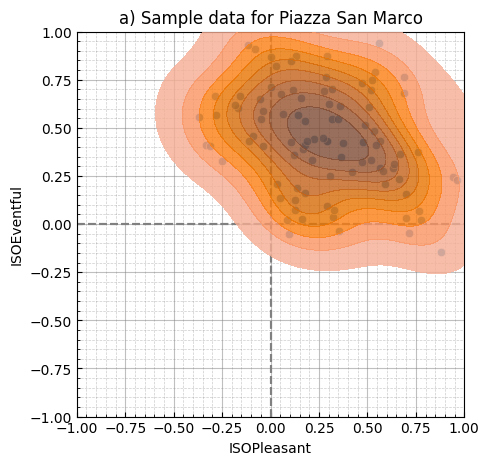

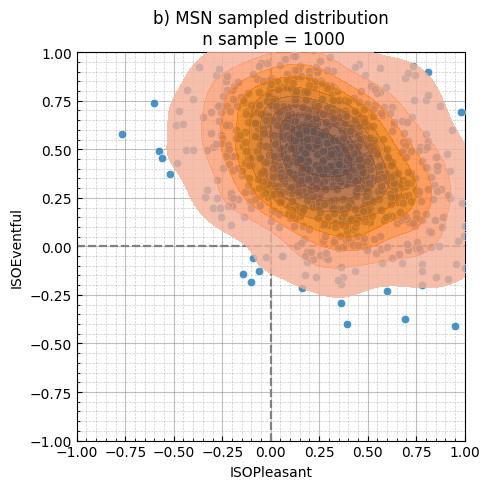

In [9]:
Y = msn.sample(1000, return_sample=True)
Y = pd.DataFrame(Y, columns=["ISOPleasant", "ISOEventful"])
D, p = msn.ks2ds(test_data[["ISOPleasant", "ISOEventful"]])

sspy.density_plot(
    test_data,
    density_type="full",
    title=f"a) Sample data for Piazza San Marco",
)
sspy.density_plot(
    Y, density_type="full", title="b) MSN sampled distribution\n n sample = 1000"
)
plt.tight_layout()

In [10]:
# Universal pleasant target
target_1 = MultiSkewNorm()
target_1.define_dp(
    xi = np.array([0.5, 0.0]),
    omega = np.array(
        [[0.2, 0],
         [0, 0.2]]),
    alpha = np.array([1, 0])
)
target_2 = MultiSkewNorm()
target_2.define_dp(
    xi = np.array([[1.0, -0.4]]),
    omega = np.array([[ 0.17, -0.04],
              [-0.04,  0.09]]),
    alpha = np.array([-8,  1])
    )

target_3 = MultiSkewNorm()
target_3.define_dp(
    xi=np.array([0.5, 0.7]),
    omega=np.array([[0.1, 0.05], [0.05, 0.1]]),
    alpha=np.array([0, -5]),
)

Y_1 = target_1.sample(1000, return_sample=True)
Y_1 = pd.DataFrame(Y_1, columns=["ISOPleasant", "ISOEventful"])
Y_2 = target_2.sample(1000, return_sample=True)
Y_2 = pd.DataFrame(Y_2, columns=["ISOPleasant", "ISOEventful"])
Y_3 = target_3.sample(1000, return_sample=True)
Y_3 = pd.DataFrame(Y_3, columns=["ISOPleasant", "ISOEventful"])


In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sspy.density_plot(
    Y_1,
    ax=axes[0],
    density_type="full",
    title="a) Target 1",
    color='red',
)
sspy.density_plot(
    Y_2, ax=axes[1], density_type="full", title="b) Target 2", color='red'
)
sspy.density_plot(
    Y_3, ax=axes[2], density_type="full", title="c) Target 3", color='red'
)

In [12]:
D_1 = msn_utils.ks2d2s(
    test_data = test_data[['ISOPleasant', 'ISOEventful']],
    target_data = Y_1,
    extra=True
)
D_2 = msn_utils.ks2d2s(
    test_data = test_data[['ISOPleasant', 'ISOEventful']],
    target_data = Y_2,
    extra=True
)
D_3 = msn_utils.ks2d2s(
    test_data = test_data[['ISOPleasant', 'ISOEventful']],
    target_data = Y_3,
    extra=True
)

In [13]:
from IPython.display import Markdown
from tabulate import tabulate

D_tbl = [['tgt_1', D_1[1].round(2), D_1[0]],
         ['tgt_2', D_2[1].round(2), D_2[0]],
         ['tgt_3', D_3[1].round(2), D_2[0]]]
Markdown(tabulate(
    D_tbl,
    headers = ["Target", "D", "p"],
    tablefmt='grid'
))

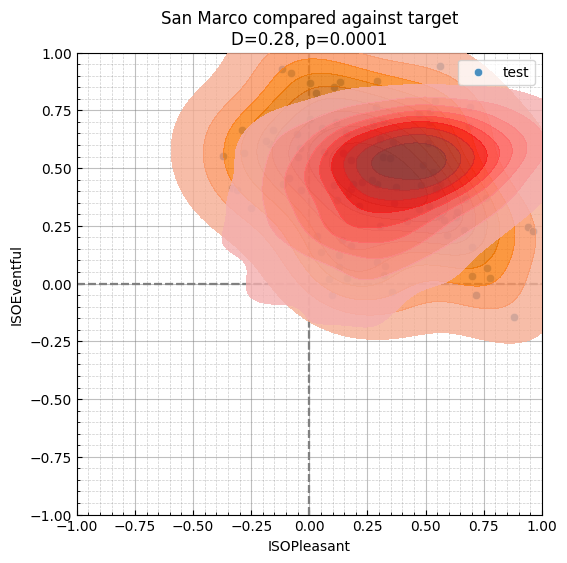

In [14]:
fig, ax = plt.subplots(figsize=(6, 6))

sspy.density_plot(
    sspy.isd.select_location_ids(data, "SanMarco"),
    ax=ax,
    density_type="simple",
    label='test',
)

tmp_data = pd.DataFrame(
    {"ISOPleasant": target_3.sample_data[:, 0], "ISOEventful": target_3.sample_data[:, 1]}
)
sspy.density_plot(
    tmp_data,
    ax=ax,
    incl_scatter=False,
    density_type="simple",
    label='target',
    title=f"San Marco compared against target\nD={D_3[1].round(2)}, p={D_3[0].round(4)}",
    color='red'
)

In [15]:
spis = {}
for location in data.LocationID.unique():
    loc_data = sspy.isd.select_location_ids(data, location)[['ISOPleasant', 'ISOEventful']]
    spi_res = [msn_utils.spi(loc_data, target_data) for target_data in [Y_1, Y_2, Y_3]]
    spis[location] = spi_res
spis_df = pd.DataFrame(spis).T
spis_df.columns = ['tgt_1', 'tgt_2', 'tgt_3']
# spis_df

In [16]:
def table_fill(spis_df, idx):
    tgt_1_order = spis_df['tgt_1'].sort_values(ascending=False)
    tgt_2_order = spis_df['tgt_2'].sort_values(ascending=False)
    tgt_3_order = spis_df['tgt_3'].sort_values(ascending=False)

    def tgt_str(tgt_order, idx):
        return f"{tgt_order.values[idx]}   {tgt_order.index[idx]}"

    return [f"{idx+1}", tgt_str(tgt_1_order, idx), tgt_str(tgt_2_order, idx), tgt_str(tgt_3_order, idx)]


In [17]:
spis_tbl = [table_fill(spis_df, idx) for idx in range(len(spis_df))]
tabulate.PRESERVE_WHITESPACE = True
Markdown(tabulate(
    spis_tbl,
    headers = ["Ranking", "$SPI_1$ (pleasant)", "$SPI_2$ (calm)", "$SPI_3$ (vibrant)"],
    tablefmt='pipe',
))

In [18]:
spis_df['tgt_1'].sort_values(ascending=False)

RegentsParkFields     70
CarloV                68
RegentsParkJapan      65
CampoPrincipe         60
RussellSq             60
MarchmontGarden       59
PlazaBibRambla        58
MonumentoGaribaldi    58
PancrasLock           56
StPaulsCross          49
TateModern            45
StPaulsRow            45
MiradorSanNicolas     40
Noorderplantsoen      38
TorringtonSq          35
SanMarco              30
CamdenTown            20
EustonTap             15
Name: tgt_1, dtype: int64

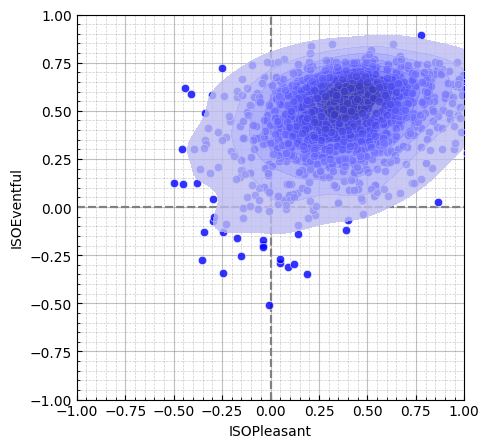

In [19]:
target = MultiSkewNorm()
target.define_dp(
    xi=np.array([0.5, 0.7]),
    omega=np.array([[0.1, 0.05], [0.05, 0.1]]),
    alpha=np.array([0, -5]),
)
target.sample(1000)
target.sspy_plot()

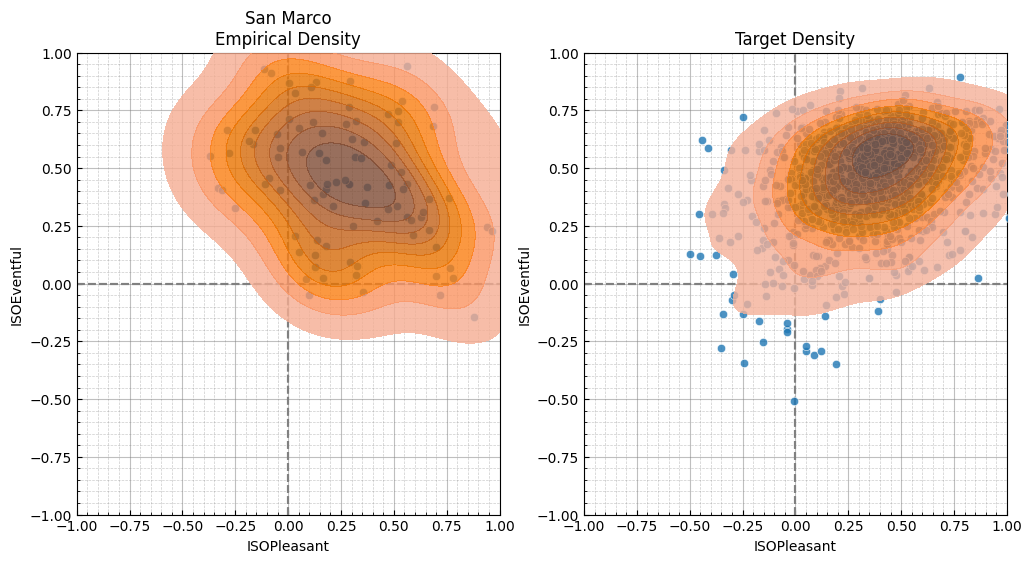

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sspy.density_plot(
    test_data, incl_scatter=True, title="San Marco\nEmpirical Density", ax=axes[0]
)
sspy.density_plot(
    pd.DataFrame(target.sample_data, columns=["ISOPleasant", "ISOEventful"]),
    incl_scatter=True,
    title="Target Density",
    ax=axes[1],
)

Once the target is defined, we will generate a set of points that
represent the target distribution.

Now that our target has been defined, we can calculate the SPI for a
given set of responses. We will use the responses from Piazza San Marco
in Venice, Italy, as an example.

In [21]:
test_spi = target.spi(data.query("LocationID == 'SanMarco'")[["ISOPleasant", "ISOEventful"]])
print(f"San Marco SPI = {test_spi}")

San Marco SPI = 72

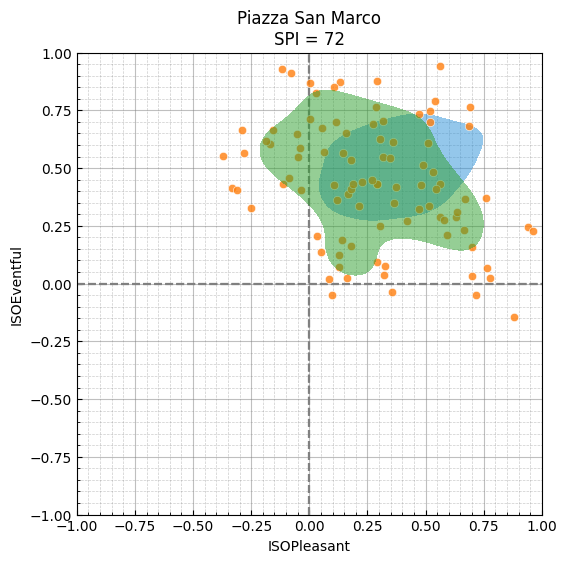

In [22]:
fig, ax = plt.subplots(figsize=(6, 6))

tmp_data = pd.DataFrame(
    {"ISOPleasant": target.sample_data[:, 0], "ISOEventful": target.sample_data[:, 1]}
)

sspy.density_plot(
    tmp_data,
    ax=ax,
    incl_scatter=False,
    simple_density=True,
    title="",
)
sspy.density_plot(
    sspy.isd.select_location_ids(data, "SanMarco"),
    ax=ax,
    simple_density=True,
    title=f"Piazza San Marco\nSPI = {test_spi}",
)

We can compare this against another location, such as St Pancras Lock.

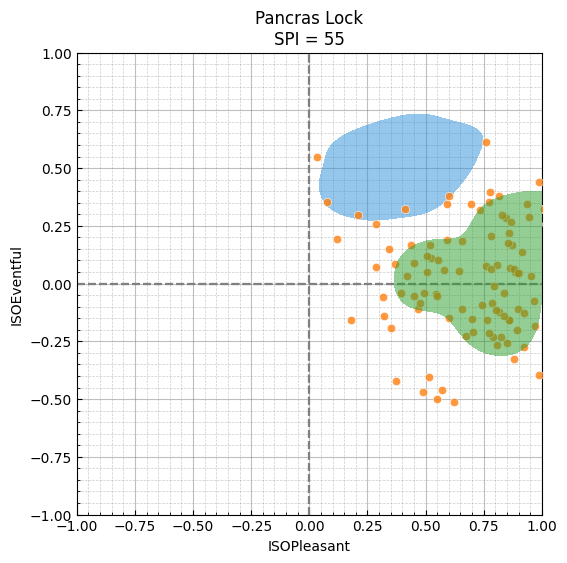

In [23]:
test_spi = target.spi(
    sspy.isd.select_location_ids(data, "PancrasLock")[["ISOPleasant", "ISOEventful"]]
)
fig, ax = plt.subplots(figsize=(6, 6))

tmp_data = pd.DataFrame(
    {"ISOPleasant": target.sample_data[:, 0], "ISOEventful": target.sample_data[:, 1]}
)

sspy.density_plot(
    tmp_data,
    ax=ax,
    incl_scatter=False,
    simple_density=True,
    title="",
)
sspy.density_plot(
    sspy.isd.select_location_ids(data, "RegentsParkFields"),
    ax=ax,
    simple_density=True,
    title=f"Pancras Lock\nSPI = {test_spi}",
)

SPI scores assessed against a target should not inherently be considered
a measure of the quality of the soundscape - instead it reflects the
degree to which the soundscape matches the target. A high SPI score does
not necessarily mean that the soundscape is of high quality, but rather
that the soundscape is of high quality *according to the target*.

The $SPI_{bespoke}$ thus provides a method for scoring and ranking the
success of a soundscape design against the designer’s goals. Sticking
with our defined target, we can assess all of the locations in the ISD
and see which locations best match our target.

In [24]:
loc_bespoke = {}
for location in data.LocationID.unique():
    loc_bespoke[location] = target.spi(
        sspy.isd.select_location_ids(data, location)[["ISOPleasant", "ISOEventful"]]
    )

loc_bespoke = pd.DataFrame.from_dict(loc_bespoke, orient="index", columns=["SPI"])
loc_bespoke.sort_values(by="SPI", ascending=False, inplace=True)
loc_bespoke

Assessed against a different target would result in a different ranking:

Fitted from direct parameters.
Direct Parameters:
xi:    [-0.5 -0.5]
omega: [[0.1 0. ]
 [0.  0.2]]
alpha: [-0.85  1.5 ]


None

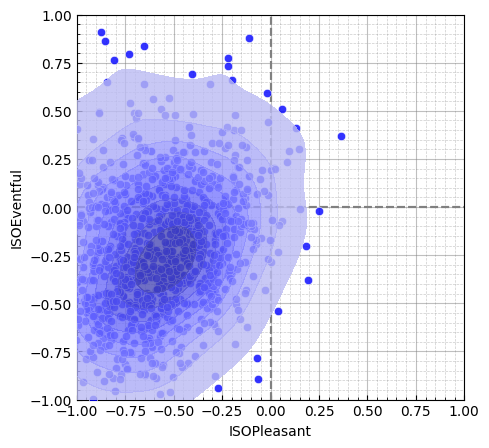

In [25]:
target = MultiSkewNorm()
target.define_dp(
    np.array([-0.5, -0.5]),
    np.array([[0.1, 0], [0, 0.2]]),
    np.array([-0.85, 1.5]),
)
target.summary()

target.sample(n=1000)
target.sspy_plot()

In [26]:
loc_bespoke_2 = {}
for location in data.LocationID.unique():
    loc_bespoke_2[location] = target.spi(
        sspy.isd.select_location_ids(data, location)[["ISOPleasant", "ISOEventful"]]
    )

loc_bespoke_2 = pd.DataFrame.from_dict(loc_bespoke_2, orient="index", columns=["SPI"])
loc_bespoke_2.sort_values(by="SPI", ascending=False, inplace=True)
loc_bespoke_2

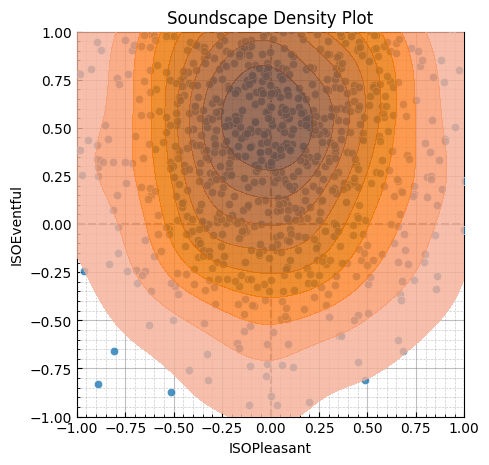

In [27]:
target1 = MultiSkewNorm()
target1.define_dp(
    np.array([-0.5, 0.5]), np.array([[0.1, 0], [0, 0.1]]), np.array([0, 0])
)
target1.sample()

target2 = MultiSkewNorm()
target2.define_dp(np.array([0.5, 0]), np.array([[0.1, 0], [0, 0.2]]), np.array([0, 0]))
target2.sample()

target_mix_y = target1.sample_data + target2.sample_data

target_mix_y = pd.DataFrame(target_mix_y, columns=["ISOPleasant", "ISOEventful"])

sspy.density_plot(target_mix_y)